Import some essential libraries

In [1]:
# Essentials
import pickle
import os
import math
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

# PyTorch
import torch
import torchvision
import torch.nn as nn  
import torch.nn.functional as F  
import torchvision.datasets as datasets  
import torchvision.transforms as transforms  
from torch.utils.data import DataLoader

In [2]:
torch.__version__

'1.9.0'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Resources

In [4]:
# Imagenet normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),  
        transforms.RandomHorizontalFlip(),  # augmentations
        transforms.ToTensor(),
        transforms.Normalize(mean, std)  
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

# 1. Import data, split to train, validation, test set:

In [5]:
# Directories
data_dir = "/storage/intern"
label_path = "./mat/MatLB3"
params_path = "./model/model_params"

In [6]:
# Define parameter
batch_size = 32
num_workers = 2

In [7]:
experiment = "mat"
# Load Data
train_set = datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"])
val_set = datasets.ImageFolder(os.path.join(data_dir, "val"), data_transforms["val"])
train_size = len(train_set)
val_size = len(val_set)

Class name

In [8]:
class_names = train_set.classes
num_class = len(class_names)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
num_batches = math.floor(train_size/batch_size)
print(f"Number of classes: {num_class}")
print(f"Number of batches: {num_batches}")
print(class_names)

Number of classes: 31
Number of batches: 1617
['calf', 'canvas', 'canvas+leather', 'coatedcanvas', 'crocodile', 'denim', 'enamel', 'flora canvas', 'fur', 'gg crystal', 'gg embossed leather', 'gg imprime ', 'gg nylon', 'gg plus', 'gg supreme canvas', 'ggcanvas', 'guccissima', 'guccissima nylon', 'jacquard ', 'leather', 'linen', 'lizard', 'microguccissima', 'nylon', 'ostrich', 'pig', 'python', 'quilted leather', 'suede', 'velor', 'velvet']


In [10]:
# Pickle class_name
f = open(label_path, "wb")
f.write(pickle.dumps(class_names))
f.close()

## Visualize the data

In [13]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


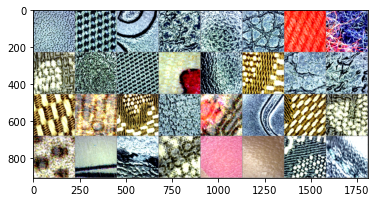

leather nylon guccissima pig   leather leather gg supreme canvas leather gg supreme canvas leather guccissima nylon flora canvas leather gg supreme canvas leather ggcanvas canvas gg supreme canvas canvas guccissima gg supreme canvas enamel ggcanvas gg supreme canvas gg supreme canvas leather quilted leather gg supreme canvas leather leather canvas leather


In [15]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = iter(train_loader).next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{class_names[labels[j]]:5s}' for j in range(batch_size)))

# 2. Compose the model

Create the base model from the pre-trained EfficientNetB4

In [16]:
# Model
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b0', pretrained=True)
in_fc = model.classifier.fc.in_features
model.classifier.fc = nn.Linear(in_fc, num_class)

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:18: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/efficientnet_widese_b0_pyt_amp/versions/20.12.0/files/nvidia_efficientnet-widese-b0_210412.pth" to /root/.cache/torch/hub/checkpoints/nvidia_efficientnet-widese-b0_210412.pth


  0%|          | 0.00/32.4M [00:00<?, ?B/s]

In [19]:
losses = []
accuracies = []

In [21]:
num_epochs = 8
learning_rate = 0.01

torch.cuda.empty_cache()

# Initialize network
model.to(device)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Progress bar
outer = tqdm(total=num_epochs, unit="epochs", position=0, desc="Epoch")
batch_log = tqdm(total=0, position=3, bar_format='{desc}')

# Train
epoch_dict = {}
step = 0
for epoch in range(num_epochs):
    inner = tqdm(total=num_batches, unit="batches", position=1, desc="Batch")
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)                          # N, C, W, H
        labels = labels.to(device)                          # N

        # forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predictions = outputs.max(1)                     # N
        step_accuracy = (predictions == labels).sum() / inputs.shape[0]
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        step += 1        
        
        # Output training stats
        if batch_idx % 50 == 0:
            print("[%d/%d][%d/%d]\tLoss: %.4f\tAccuracy: %.4f"
                  % (epoch, num_epochs, batch_idx, len(train_loader),
                     loss.item(), step_accuracy))
        # Save Losses for plotting later
        losses.append(loss.item())
        accuracies.append(step_accuracy)
        
        # Update progression bar
        batch_log.set_description_str(f"loss: {round(loss.item(), 4)}, accuracy: {step_accuracy}")
        inner.update(1)
    outer.update(1)

print("Training completed.")
        

Epoch:   0%|          | 0/8 [00:00<?, ?epochs/s]

Batch:   0%|          | 0/1617 [00:00<?, ?batches/s]

[0/8][0/1618]	Loss: 0.9434	Accuracy: 0.7812
[0/8][50/1618]	Loss: 1.3468	Accuracy: 0.5312
[0/8][100/1618]	Loss: 0.7282	Accuracy: 0.7812
[0/8][150/1618]	Loss: 1.0150	Accuracy: 0.5625
[0/8][200/1618]	Loss: 1.4599	Accuracy: 0.6250
[0/8][250/1618]	Loss: 0.5766	Accuracy: 0.8125
[0/8][300/1618]	Loss: 1.2674	Accuracy: 0.5938
[0/8][350/1618]	Loss: 0.6425	Accuracy: 0.8125
[0/8][400/1618]	Loss: 1.0609	Accuracy: 0.5938
[0/8][450/1618]	Loss: 0.5247	Accuracy: 0.8438
[0/8][500/1618]	Loss: 1.0700	Accuracy: 0.5938
[0/8][550/1618]	Loss: 0.5799	Accuracy: 0.7500
[0/8][600/1618]	Loss: 1.0934	Accuracy: 0.6562
[0/8][650/1618]	Loss: 0.9272	Accuracy: 0.7812
[0/8][700/1618]	Loss: 0.3459	Accuracy: 0.8750
[0/8][750/1618]	Loss: 1.0052	Accuracy: 0.7500
[0/8][800/1618]	Loss: 0.5706	Accuracy: 0.8438
[0/8][850/1618]	Loss: 0.5174	Accuracy: 0.8750
[0/8][900/1618]	Loss: 0.5733	Accuracy: 0.8438
[0/8][950/1618]	Loss: 0.4746	Accuracy: 0.8125
[0/8][1000/1618]	Loss: 0.2551	Accuracy: 0.9062
[0/8][1050/1618]	Loss: 0.6859	Accura

In [21]:
# Save model parameters
torch.save(model.state_dict(), params_path)

In [ ]:
# Plot
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(accuracies,label="G")
plt.plot(losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Predict on test set

In [ ]:
dataiter = iter(val_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{class_names[labels[j]]:5s}' for j in range(4)))

Predictions:
 [18 15  5 16 34  5 16 17 16 20  5 16 17 17 20 17  5 16 19 20 20 20 20 20
 16 20 17 20  6 16  5 18]
Labels:
 [17  6  5 16 16  5 16 17 16 20 11 16 17 17 20 17 17 16 19 20  5 20 20 20
 16  5 17 20  6 16  5 20]


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65424 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65414 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65405 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65420 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65432 missing from current font.
  font.set_

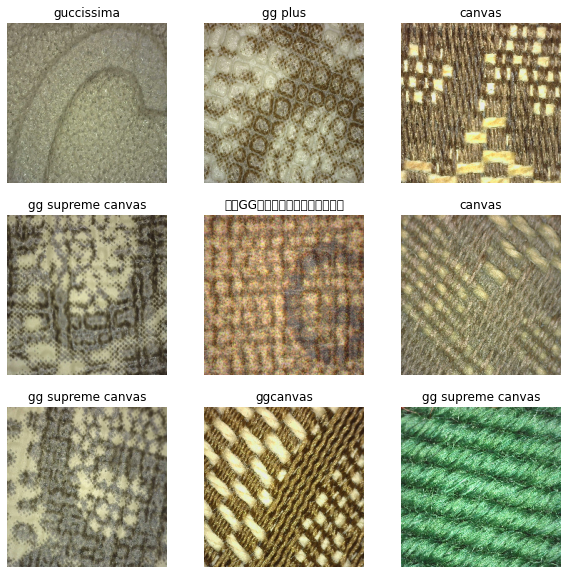

In [28]:
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{class_names[predicted[j]]:5s}'
                              for j in range(4)))

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

# again no gradients needed
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')